<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture03/notebooks/L03_FFNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

- Universal Approximation Theorem


--- Demonstrating with 8 hidden neurons ---
Epoch [1000/3000], Loss: 0.005373
Epoch [2000/3000], Loss: 0.005329
Epoch [3000/3000], Loss: 0.005328


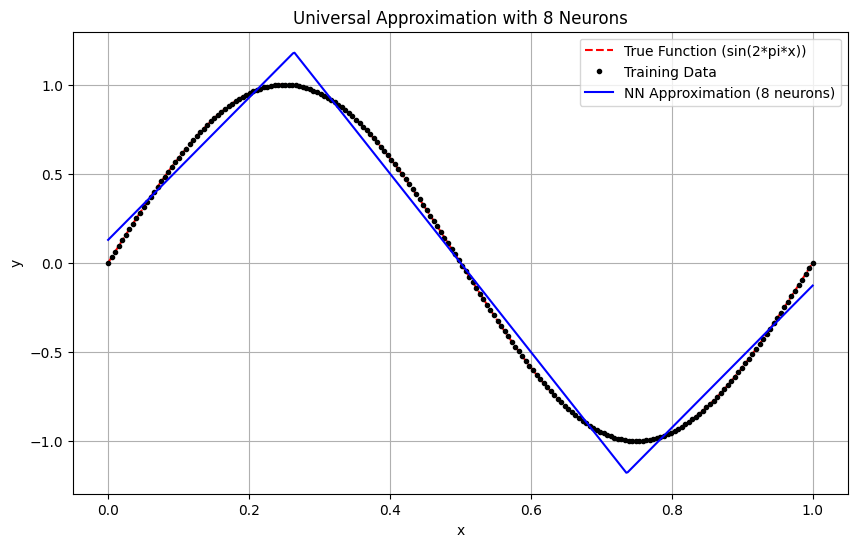


--- Demonstrating with 64 hidden neurons ---
Epoch [1000/3000], Loss: 0.002668
Epoch [2000/3000], Loss: 0.001623
Epoch [3000/3000], Loss: 0.000824


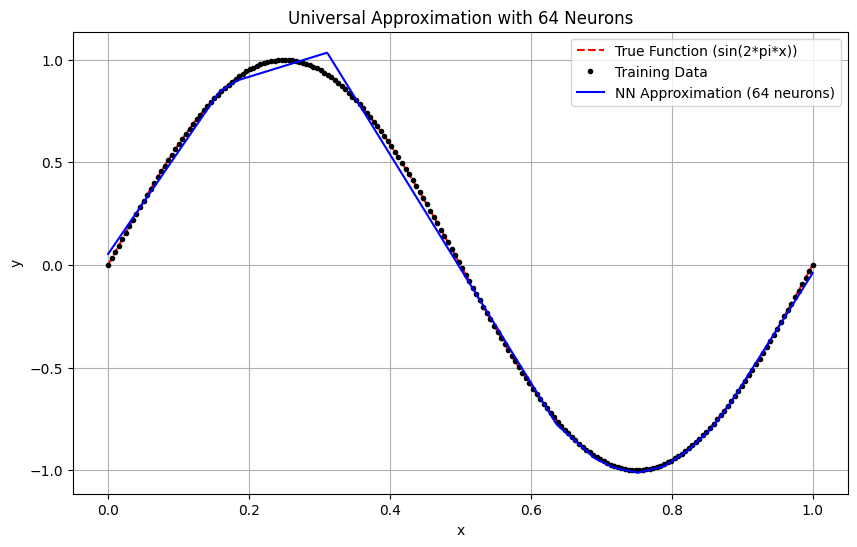


--- Demonstrating with 256 hidden neurons ---
Epoch [1000/3000], Loss: 0.000008
Epoch [2000/3000], Loss: 0.000008
Epoch [3000/3000], Loss: 0.000007


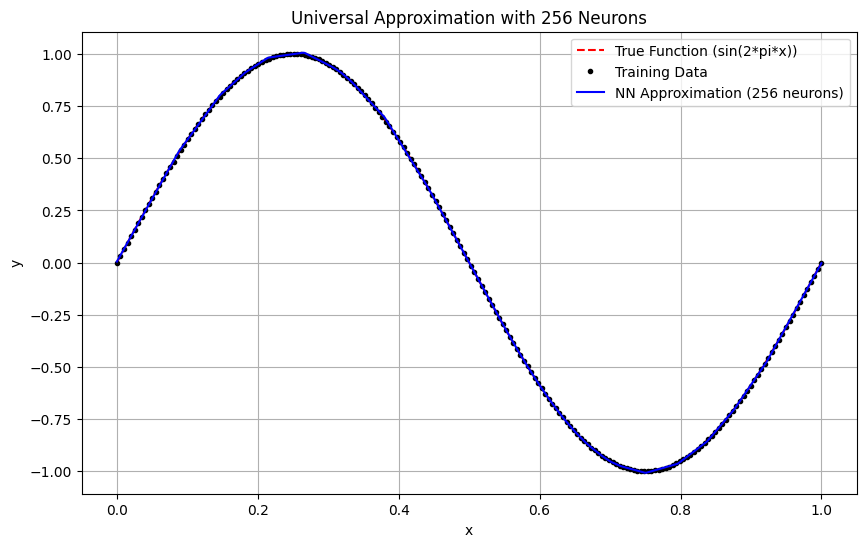

In [ ]:
# -- 1. Define the Target Function and Data --
# Let's try to approximate the sin function
def target_function(x):
    return np.sin(x * 2 * np.pi)

# Generate training data
# We create 200 points between 0 and 1
X_train = torch.linspace(0, 1, 200).view(-1, 1)
y_train = torch.tensor(target_function(X_train.numpy()), dtype=torch.float32)

# Generate test data for a smooth plot
X_test = torch.linspace(0, 1, 500).view(-1, 1)
y_test_true = torch.tensor(target_function(X_test.numpy()), dtype=torch.float32)


# -- 2. Create a function to build, train, and plot --
def demonstrate_uat(num_neurons, epochs=3000):
    """
    Builds and trains a model with a specified number of hidden neurons
    and plots its approximation of the target function.
    """
    print(f"\n--- Demonstrating with {num_neurons} hidden neurons ---")

    # Define the model: 1 input -> hidden_layer -> 1 output
    model = nn.Sequential(
        nn.Linear(1, num_neurons),
        nn.ReLU(),
        nn.Linear(num_neurons, 1)
    )

    # Loss and optimizer for regression
    criterion = nn.MSELoss() # Mean Squared Error is perfect for regression
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

    # -- 3. Visualization --
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        y_pred_final = model(X_test)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_test.numpy(), y_test_true.numpy(), 'r--', label='True Function (sin(2*pi*x))')
    plt.plot(X_train.numpy(), y_train.numpy(), 'ko', markersize=3, label='Training Data')
    plt.plot(X_test.numpy(), y_pred_final.numpy(), 'b-', label=f'NN Approximation ({num_neurons} neurons)')
    plt.title(f'Universal Approximation with {num_neurons} Neurons')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Let's run the demonstration with different capacities ---
demonstrate_uat(num_neurons=8)   # Too little capacity -> Underfitting
demonstrate_uat(num_neurons=64)  # Good capacity -> Good fit
demonstrate_uat(num_neurons=256) # High capacity -> Very good fit

- Deep vs Wide Architecture

--- Training Wide Model (1x64) ---
Epoch [200/1000], Loss: 0.2818
Epoch [400/1000], Loss: 0.2808
Epoch [600/1000], Loss: 0.2808
Epoch [800/1000], Loss: 0.2807
Epoch [1000/1000], Loss: 0.2807
Accuracy of Wide Model (1x64): 86.67%


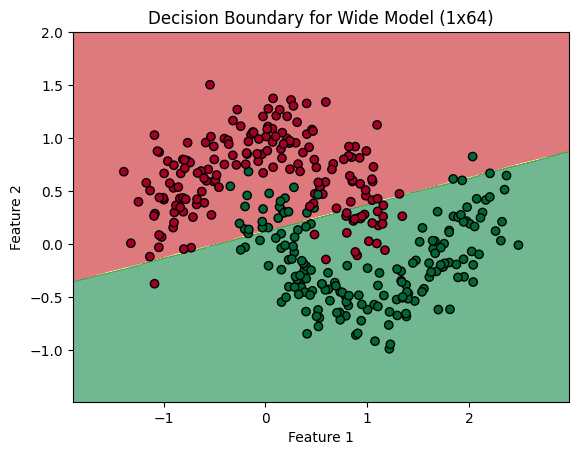

--- Training Deep Model (3x8) ---
Epoch [200/1000], Loss: 0.0163
Epoch [400/1000], Loss: 0.0115
Epoch [600/1000], Loss: 0.0074
Epoch [800/1000], Loss: 0.0039
Epoch [1000/1000], Loss: 0.0013
Accuracy of Deep Model (3x8): 95.33%


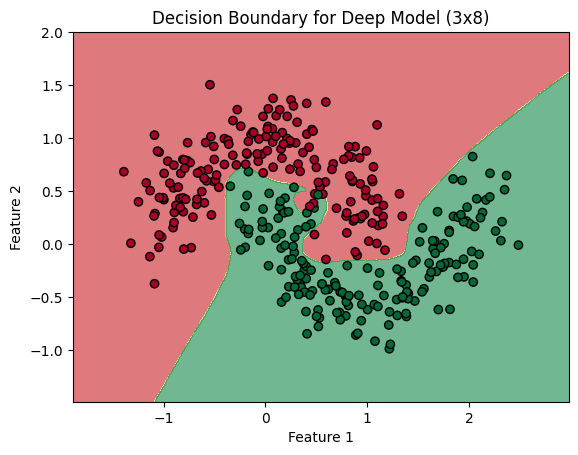

In [ ]:
# -- 1. Data Preparation --
# Generate a non-linearly separable dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert numpy arrays to PyTorch tensors
# The features need to be FloatTensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# The labels need to be FloatTensors for BCEWithLogitsLoss, with an extra dimension
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)


# -- 2. Helper Function to Plot Decision Boundary --
def plot_decision_boundary(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad(): # We don't need to compute gradients for this
        Z = model(grid_tensor)
        Z = torch.sigmoid(Z) # Apply sigmoid to get probabilities
        Z = (Z > 0.5).long() # Convert to binary predictions (0 or 1)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdYlGn, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# -- 3. Define, Train, and Evaluate Models --

def train_and_evaluate(model, model_name):
    print(f"--- Training {model_name} ---")
    # Loss and optimizer
    # BCEWithLogitsLoss is great for binary classification as it's numerically stable
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    epochs = 1000

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).long()
        acc = accuracy_score(y_test.numpy(), y_pred_class.numpy())
        print(f'Accuracy of {model_name}: {acc * 100:.2f}%')

    # Plot the decision boundary
    plot_decision_boundary(model, X_train.numpy(), y_train, f'Decision Boundary for {model_name}')

# --- Model 1: Wide and Shallow (1 hidden layer with many neurons) ---
n_hidden = 5
model_wide = nn.Sequential(
    nn.Linear(2, n_hidden), # Input features = 2, hidden neurons = 64
    nn.ReLU(),
    nn.Linear(n_hidden, 1)   # Output features = 1 (for binary classification)
)
train_and_evaluate(model_wide, "Wide Model (1x64)")


# --- Model 2: Deep and Narrow (several hidden layers with fewer neurons) ---
model_deep = nn.Sequential(
    nn.Linear(2, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)
train_and_evaluate(model_deep, "Deep Model (3x8)")

- Latent Space Visualization

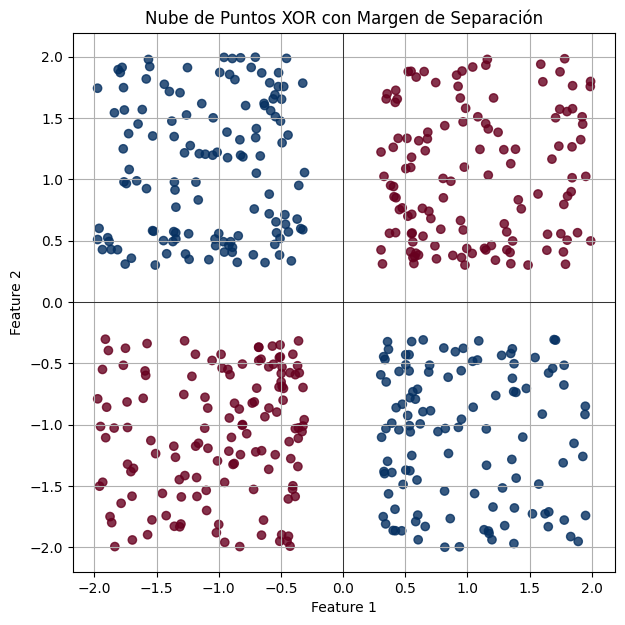

In [17]:
# -- 1. Data Preparation (Moons dataset) --
# Generate a larger cloud of points
def create_xor_cloud(n_samples=500, margin=0.3):
    """
    Creates a 2D point cloud with an XOR-like distribution.
    Includes a 'margin' around the axes to better separate the clouds.
    """
    # Generate random points in a square
    X_data = np.random.uniform(low=-2, high=2, size=(n_samples, 2))

    # --- NEW LOGIC: Push points away from the center axes ---
    # For each point (x, y), if it's within the margin, move it out.
    x_abs = np.abs(X_data[:, 0])
    y_abs = np.abs(X_data[:, 1])

    # Identify points inside the margin
    x_in_margin = x_abs < margin
    y_in_margin = y_abs < margin

    # Move them out by adding the margin to their absolute value
    X_data[x_in_margin, 0] = (x_abs[x_in_margin] + margin) * np.sign(X_data[x_in_margin, 0])
    X_data[y_in_margin, 1] = (y_abs[y_in_margin] + margin) * np.sign(X_data[y_in_margin, 1])

    # Assign labels based on the XOR logic of the quadrants (this remains the same)
    y_data = np.logical_xor(X_data[:, 0] > 0, X_data[:, 1] > 0).astype(int)

    return X_data, y_data

# --- Generate and visualize the new data to confirm the gap ---
X_numpy, y_numpy = create_xor_cloud(n_samples=500, margin=0.3)
X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy, dtype=torch.float32).view(-1, 1)

plt.figure(figsize=(7, 7))
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], c=y_numpy, cmap=plt.cm.RdBu, alpha=0.8)
plt.title("Nube de Puntos XOR con Margen de Separación")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.show()

In [14]:
# -- 2. Model Definition --
# The model is the same, but we can rename it for clarity
class TransformationNet(nn.Module):
    def __init__(self):
        super(TransformationNet, self).__init__()
        self.hidden1 = nn.Linear(2, 2)
        self.activation1 = nn.Tanh()
        self.hidden2 = nn.Linear(2, 2)
        self.activation2 = nn.Tanh()
        self.output = nn.Linear(2, 1)

    def forward(self, x):
        # Pass data through the network and capture intermediate states
        pre_act1 = self.hidden1(x)
        post_act1 = self.activation1(pre_act1)
        pre_act2 = self.hidden2(post_act1)
        post_act2 = self.activation2(pre_act2)
        logits = self.output(post_act2)
        return logits, pre_act1, post_act1, pre_act2, post_act2


In [19]:
# -- 3. Visualization Helper Function --
def plot_all_visualizations(model, epoch, loss):
    # Get the intermediate representations
    with torch.no_grad():
        logits, pre1, post1, pre2, post2 = model(X)

    # Detach tensors for plotting
    points = [p.numpy() for p in [pre1, post1, pre2, post2]]
    labels = y.numpy().flatten()
    colors = ['red' if l == 0 else 'blue' for l in labels]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Epoch: {epoch} | Loss: {loss:.4f}', fontsize=20)

    # --- Plot 1: Input Data (Reference) ---
    ax = axes[0, 0]
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=15, alpha=0.7)
    ax.set_title('1. Datos de Entrada Originales')
    ax.grid(True)

    # --- Plots 2-5: Internal Representations ---
    titles = [
        '2. Capa 1 (Antes de Activación)', '3. Capa 1 (Después de Tanh)',
        '4. Capa 2 (Antes de Activación)', '5. Capa 2 (Después de Tanh)'
    ]

    plot_indices = [(0, 1), (0, 2), (1, 0), (1, 1)]
    for i, (r, c) in enumerate(plot_indices):
        ax = axes[r, c]
        data = points[i]

        # Dynamic axis limits
        x_min, x_max = data[:, 0].min() - 0.2, data[:, 0].max() + 0.2
        y_min, y_max = data[:, 1].min() - 0.2, data[:, 1].max() + 0.2
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.scatter(data[:, 0], data[:, 1], c=colors, s=15, alpha=0.7)
        ax.set_title(titles[i])
        ax.grid(True)

    # --- Plot 6: Final Decision Boundary ---
    ax = axes[1, 2]
    ax.set_title('6. Frontera de Decisión Aprendida')
    # Create a grid to plot the decision boundary
    h = 0.05
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(grid_tensor)[0] # We only need the final logits
        Z = torch.sigmoid(Z)
        Z = (Z > 0.5).long()
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=15, edgecolors='k', alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

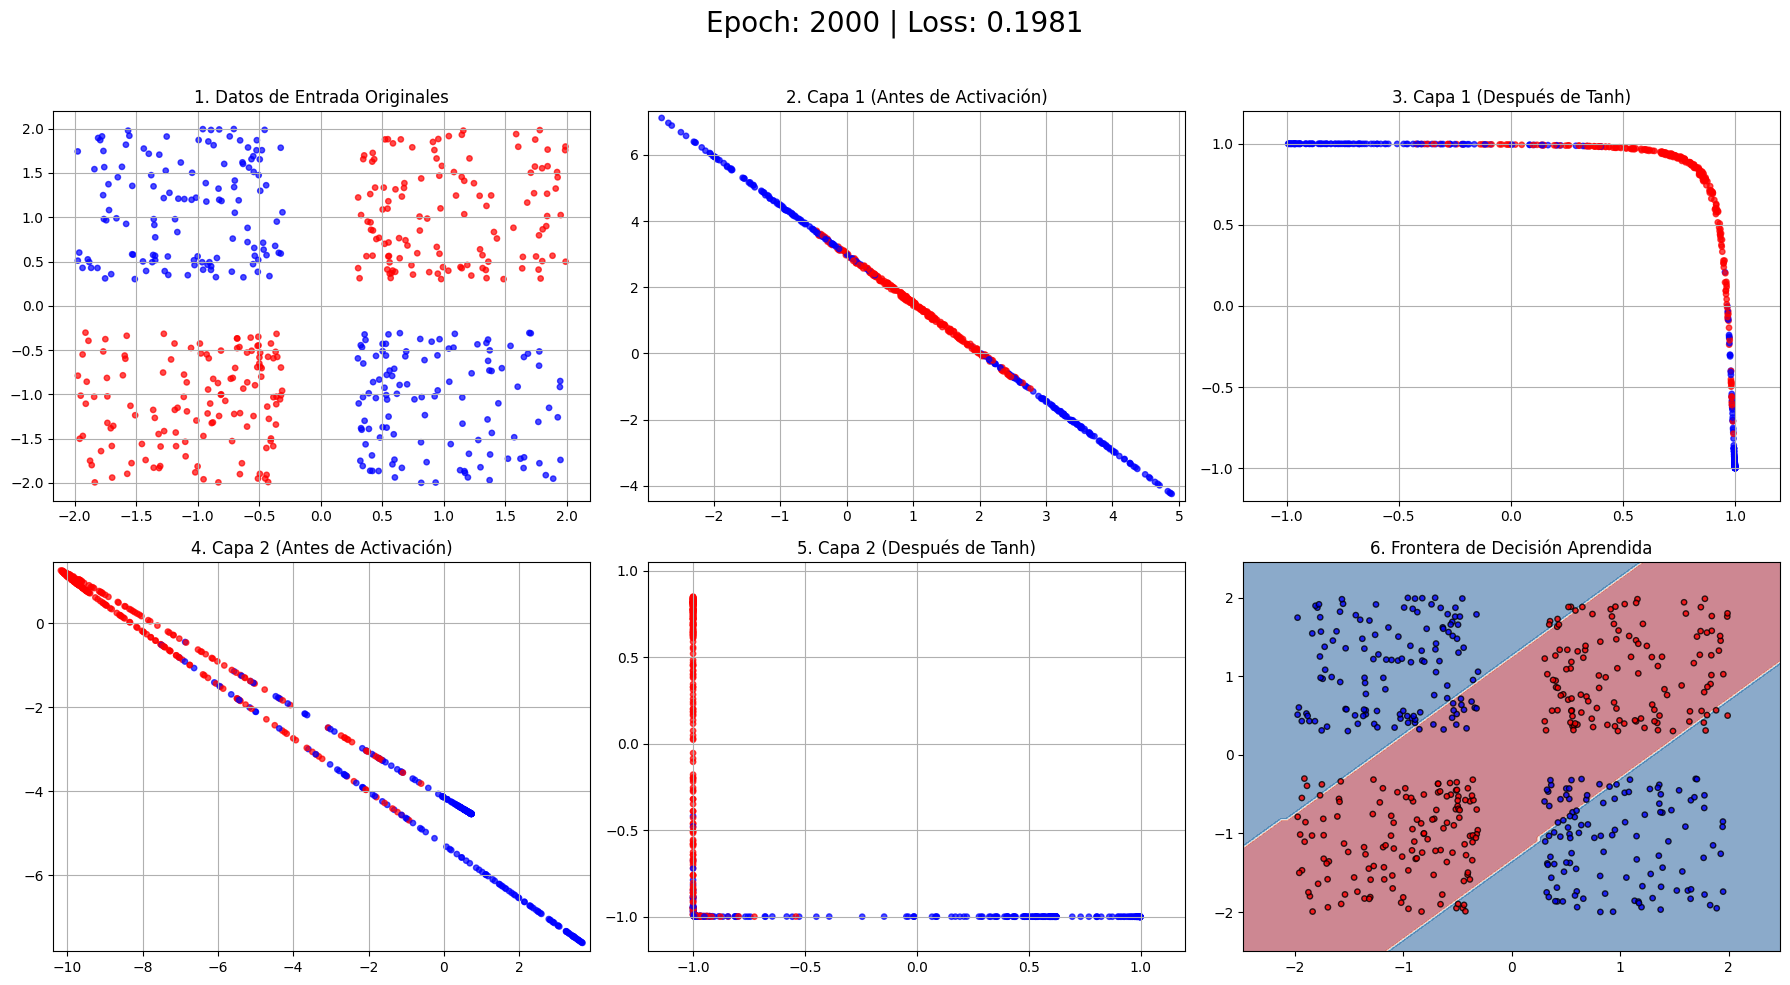

Entrenamiento finalizado.


In [21]:
# -- 4. Training Loop --
model = TransformationNet()
optimizer = optim.Adam(model.parameters(), lr=0.03)
criterion = nn.BCEWithLogitsLoss()

epochs = 2001
plot_interval = 200

# Plot initial state before training
with torch.no_grad():
    initial_loss = criterion(model(X)[0], y)
plot_all_visualizations(model, epoch=0, loss=initial_loss.item())


for epoch in range(1, epochs):
    # Forward pass
    logits, _, _, _, _ = model(X)
    loss = criterion(logits, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Visualization part
    if epoch % plot_interval == 0:
        clear_output(wait=True) # Clears the output for a clean animation
        plot_all_visualizations(model, epoch, loss.item())

print("Entrenamiento finalizado.")